# Push Recovery with Capture Points

**Important**: Use _nbviewer_ to look at this notebook. Github has some problems with rendering equations properly: [open this notebook in nbviewer](https://nbviewer.jupyter.org/github/ThomasSchnapka/quaro/blob/master/notebooks/Push_Recovery_Capture_Point.ipynb)

This notebook exemplifies the Balance Controller for quadrupedal robots described in this paper: [Capturability-based analysis and control
of legged locomotion](https://www.researchgate.net/publication/255757664_Capturability-based_analysis_and_control_of_legged_locomotion_Part_1_Theory_and_application_to_three_simple_gait_models). 

The goal is to determine a feasable point (the so-called _capture point_) the leg has to step at in order to prevent the robot from falling.

### Linear Inverted Pendulum Model

In this paper, the robot is modelled as a _Linear Inverted Pendulum_ (LIMP) which is f.e. used for slope  control in the current Quaro control software.

The LIMP approximates the robot as a inverted pendulum with a point mass at the robots COM $p_{COM}$ at constant height $z_{COM}$. The foot is described as a point mass, too, and has the location $p_{leg}$. Both heights $z_{COM}$ and $z_{COM}$ are constant and the mass points are connected by a massless, telescoping mechanism of variable length.

The projection matrix $\textbf{P}$ projects the COM position $p_{COM}$ onto the leg plane.

Visualization in 2D expressed in robot base coordinates:

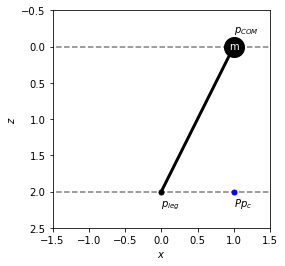

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# constants
z_com = 0
z_leg = 2
z0 = z_com-z_leg
p_com = np.array([1, z_com, 1])
p_leg = np.array([0, z_leg, 1])
P = np.array([[1, 0,   0],
              [0, 1, -z0],
              [0, 0,   1]])

# plot
def plot_limp(p_com, p_leg, P):
    plt.plot([p_com[0], p_leg[0]],[p_com[1], p_leg[1]],"k", linewidth=3)
    plt.plot(p_com[0], p_com[1], "ko", markersize=20)
    plt.text(p_com[0], p_com[1]-0.2, "$p_{COM}$")
    plt.text(p_com[0], p_com[1], "m", color="white", va="center", ha="center")
    plt.plot(p_leg[0], p_leg[1], "ko", markersize=5)
    plt.text(p_leg[0], p_leg[1]+0.2, "$p_{leg}$")
    p_trans = P@p_com
    plt.plot(p_trans[0], p_trans[1], "bo", markersize=5)
    plt.text(p_trans[0], p_trans[1]+0.2, "$Pp_c$")

plot_limp(p_com, p_leg, P)
plt.hlines([z_com, z_leg], -10, 10, color="gray", linestyles="--")
plt.xlim(-1.5, 1.5)
plt.ylim(2.5, -0.5)
plt.xlabel("$x$")
plt.ylabel("$z$")
plt.gca().set_aspect('equal', adjustable='box')

Assuming that the force $f$ is acting through the limb from the leg point onto the COM, the equations of motions are:

$$
m\ddot{\textbf{p}}_\mathrm{COM} = \textbf{f} + m\textbf{g}
$$

Since the force vector always points in the same direction as the limb:

$$
-(\textbf{p}_\mathrm{COM} - \textbf{p}_\mathrm{leg}) \times \textbf{f} = \textbf{0}
$$

The COM mass will stay at height $z_0$ if $\dot{z}_\mathrm{COM}$ and $\ddot{z}_\mathrm{COM} = 0$. With this assumption the two equations above we get:

$$
f_x = m\omega^2_0(x_\mathrm{COM} - x_\mathrm{leg})\\
f_y = m\omega^2_0(y_\mathrm{COM} - y_\mathrm{leg})\\
f_z = mg
$$

with $\omega_0 = \sqrt{\frac{g}{z_0}}$, which is the inverse of the time constant of the LIMP. Now we can write $\ddot{\textbf{p}}_\mathrm{COM}$ as:

$$
\ddot{\textbf{p}}_\mathrm{COM} = \omega^2_0(\textbf{Pp}_\mathrm{COM} - \textbf{p}_\mathrm{leg})
$$

where the points are given in homogeneous coordinates and $\textbf{P}$ is a homogeneous transformation matrix:

$$
\textbf{P} = 
\left( 
\begin{array}{cccc}
    1 & 0 & 0 & 0\\ 
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & -z_0\\
    0 & 0 & 0 & 1\\
\end{array}
\right)
$$

The equation of motion is linear and decoupled, thus we can look at motions in x- and y-direction separately. 

##### Removing dimensionality
To simplify further calculations, dimensionless quantities are defined:

$$
\textbf{p}' = \frac{\textbf{p}}{z_0}, \quad \textbf{p}_\mathrm{COM}' = \frac{\textbf{p}_\mathrm{COM}}{z_0}, \quad t' = omega_0 t
$$

$$
\dot{\textbf{p}}' = \frac{\dot{\textbf{p}}}{z_0 \omega_0}
$$

$$
\ddot{\textbf{p}}' = \frac{\ddot{\textbf{p}}}{z_0 \omega_0} = \frac{\ddot{\textbf{p}}}{g}
$$

So our system description becomes:

$$
\ddot{\textbf{p}}_\mathrm{COM}' = \textbf{Pp}_\mathrm{COM}' - \textbf{p}_\mathrm{leg}'
$$

### Constraints

The paper introduced two constraints for the allowable control inputs for the system:
1. There exists an upper bound on the step length, i.e. the distance between two steps $l_\mathrm{max}$
2. $\Delta t_s$ denotes the lower limit to the time between steps which results of the swing phase dynamic

### Capture Points
There are two types of capture points: An _instantaneous capture point_ is the point for which the COM would come into a stable position if the leg tip would be placed here. The instantaneous capture point must not be necessarily lie within the feasible area defined by the given constraints. For example, several steps might be necessary to reach the instantaneous capture point. The definition of a _capture point_ is to be feasible.

Firstly, let's take a look at the instantaneous capture point:

#### 1) Instantaneous Capture Point
Viewing the LIMP as an optimal control problem, the Hamiltonian (function to be maximized) is given by:

$$
H(\textbf{p}_\mathrm{COM},\textbf{f}) = I(\textbf{p}_\mathrm{COM},\textbf{f}) + \lambda \ddot{\textbf{p}}_\mathrm{COM}
$$

where $I(\textbf{p}_\mathrm{COM},\textbf{f}, t)$ is some kind of performance measurement. Choosing

$$
I(\textbf{p}_\mathrm{COM},\textbf{f}, t) = \frac{1}{2}\dot{\textbf{p}}_\mathrm{COM}'
$$

and

$$\lambda \ddot{\textbf{p}}_\mathrm{COM} = -\frac{1}{2}(\textbf{p}_\mathrm{COM}' - \textbf{p}_\mathrm{leg}')^2
$$

the Hamiltonian corresponds to the orbital energy:

$$
E_\mathrm{LIP, x}' = \frac{1}{2}\dot{x}_\mathrm{COM}'^2 \,-\, \frac{1}{2}(x_\mathrm{COM}'
- x_\mathrm{leg}')^2\\
\\
E_\mathrm{LIP, y}' = \frac{1}{2}\dot{y}_\mathrm{COM}'^2 \,-\, \frac{1}{2}(y_\mathrm{COM}'
- y_\mathrm{leg}')^2
$$

The orbital energy makes  a statement of the behavior of the LIMP while moving in a certain direction. If we suppose a movement in the $x$-direction, three cases come up:

1. $E_\mathrm{LIP, x}'>0$ The orbital energy is large enough for $x_\mathrm{COM}$ to reach $x_\mathrm{leg}$ but then continues to accelerate (away)
2. $E_\mathrm{LIP, x}'=0$ $x_\mathrm{COM}$ comes to a halt at $x_\mathrm{leg}$
3. $E_\mathrm{LIP, x}'<0$ The orbital energy is too small to reach the desired position, the movements stops and $x_\mathrm{COM}$ starts to accelerate in reverse direction.

Solving the given equations in order to find a $\textbf{p}_\mathrm{leg}$ for $E_\mathrm{LIP, x}'$ to be $=0$ yields:


$$
\textbf{p}_\mathrm{leg, ic}' = \textbf{Pp}' + \dot{\textbf{p}}'
$$

and with original dimensions:

$$
\textbf{p}_\mathrm{leg, ic} = \textbf{Pp} + \frac{\dot{\textbf{p}}}{\omega_0}
$$

In order to understand this result, let's make a simulation:

MovieWriter ffmpeg unavailable; using Pillow instead.


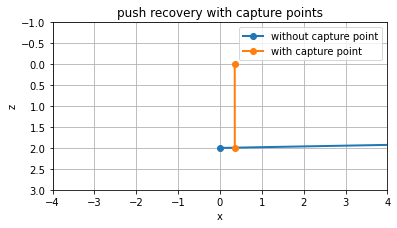

In [3]:
import matplotlib.animation as animation
from matplotlib import rc
import scipy.integrate as integrate
from IPython.display import HTML
#%matplotlib notebook

# constants
m = 1
g = 9.81
w = np.sqrt(-g/z0)
T = 3.0
t = np.arange(0, T, 0.1)

# create two states with same x_com values but one with arbitrary x_leg
# position and and one with a capture point as x_leg
x_com = -1
dx_com = 3
state = np.array([x_com, dx_com, x_com, dx_com])
x_leg = 0
x_leg_ic = state[2] + state[3]/w


def derivs(state, t):
    '''differential equations for state calculation'''
    state_dot = np.zeros_like(state)
    # with arbitrary x_leg
    state_dot[0] = state[1]
    state_dot[1] = m*w**2*(state[0] - x_leg)
    # with capture point as x_leg
    state_dot[2] = state[3]
    state_dot[3] = m*w**2*(state[2] - x_leg_ic)
    return state_dot


# integrating ODE
x = integrate.odeint(derivs, state, t)

# add plot elements
fig = plt.figure()
ax = fig.add_subplot((111), autoscale_on=False, xlim=(-4, 4), ylim=(3, -1))
ax.set_aspect('equal')
ax.set_title("push recovery with capture points")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.grid()
line0, = ax.plot([], [], 'o-', lw=2, label="without capture point")
line1, = ax.plot([], [], 'o-', lw=2, label="with capture point")

def init():
    line0.set_data([], [])
    line1.set_data([], [])
    return line0, line1

def animate(i):
    x0 = [x_leg, x[i, 0]]
    y0 = [z_leg, z_com]
    line0.set_data(x0, y0)
    x1 = [x_leg_ic, x[i, 2]]
    y1 = [z_leg,    z_com]
    line1.set_data(x1, y1)
    return line0, line1

ani = animation.FuncAnimation(fig, animate, range(1, len(x)), interval=100, init_func=init)
#HTML(ani.to_jshtml())
plt.legend()
ani.save("media/push_recovery_2D.gif")


(For better online layout, show plot in markdown instead of in Python)
![push recovery gif](media/push_recovery_2D.gif)

## Sources

- Kajita, Shuuji et al.: [The 3D Linear Inverted Pendulum Model: A simple modeling for a biped walking pattern generation](https://www.cs.cmu.edu/~hgeyer/Teaching/R16-899B/Papers/KajiitaEA01IEEE_ICIRS.pdf)
- https://en.wikipedia.org/wiki/Hamiltonian_(control_theory)